In [43]:
import yfinance
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
def fetch_sectors_names():
  url = "https://stockanalysis.com/stocks/industry/sectors/"
  response = requests.get(url)

  if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
  else:
    print(f"Error: Failed to fetch data from page {url}")
  return df


def fetch_industry_names():
  url = "https://stockanalysis.com/stocks/industry/all/"
  response = requests.get(url)
  if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
  else:
    print(f"Error: Failed to fetch data from page {url}")
  return df

def fetch_data(sectors):
  url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
  response = requests.get(url)
  if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    df.drop(columns='No.', inplace=True)
  else:
    print(f"Error: Failed to fetch data from page {url}")
  return df


# Dataları çekiyoruz ve csv dosyasına yazıyoruz
- Finans sağlık ve teknoloji sektörlerine ait hisselerin listelerini çekip csv formatında kaydediyoruz

In [ ]:
fetch_data(sectors='financials').to_csv('data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('data/stock_sectors/technology.csv')


# Dataları okuyoruz
- Kaydedilen csv formatındaki hisseleri geri çektim çünkü projeyi bir kaç günde geliştirdiğim için tekrar tekrar yfinancadan download edip sayfaya istek göndermek istemedim. Bundan sonraki csv kaydedip tekrar okumalarımın sebebi bu yüzdendir

In [40]:
finance = pd.read_csv('data/stock_sectors/financials.csv',index_col=0)
technology = pd.read_csv('data/stock_sectors/technology.csv',index_col=0)
healthcare = pd.read_csv('data/stock_sectors/healthcare.csv',index_col=0)

In [41]:
ticker_list_finance = finance.Symbol.tolist()
ticker_list_technology = technology.Symbol.tolist()
ticker_list_healthcare = healthcare.Symbol.tolist()

## Aylık Formata getiriyoruz verileri
- Aşağıda yapılan işlemlerle sırasıyla finans teknoloji ve sağlık alanındaki tickerları kullanarak verileri çekiyoruz ve aylık formata getirerek kullanmak üzere alıyoruz

In [44]:
data_finance = yfinance.download(ticker_list_finance, start='2005-01-01')
data_close_finance=data_finance[['Close']]
data_close_finance.columns = ['_'.join(col) for col in data_close_finance.columns]# MultiIndex
data_monthly_finance=data_finance['Close'].resample('ME').last().pct_change()+1

data_monthly_finance.index.name = None  # Index adını kaldır
data_monthly_finance.to_csv('data/stock_sectors/data_monthly_finance.csv', index=True)

[*********************100%***********************]  877 of 877 completed

10 Failed downloads:
['DMAA', 'RIBB', 'CRD.B', 'JACS.RT', 'SVCC', 'COLA', 'AGM.A', 'CRD.A', 'BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['TDAC']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
/var/folders/f_/s8hzn92909773ww0mcjhp6_m0000gn/T/ipykernel_3251/3677698258.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_monthly_finance=data_finance['Close'].resample('ME').last().pct_change()+1


In [ ]:
data_technology = yfinance.download(ticker_list_technology, start='2005-01-01')
data_close_technology=data_technology[['Close']]
data_close_technology.columns = ['_'.join(col) for col in data_close_technology.columns]# MultiIndex
data_monthly_technology=data_technology['Close'].resample('ME').last().pct_change()+1

data_monthly_technology.index.name = None  # Index adını kaldır
data_monthly_technology.to_csv('data/stock_sectors/data_monthly_technology.csv', index=True)


In [ ]:
data_healthcare = yfinance.download(ticker_list_healthcare, start='2005-01-01')
data_close_healthcare=data_healthcare[['Close']]
data_close_healthcare.columns = ['_'.join(col) for col in data_close_healthcare.columns]# MultiIndex
data_monthly_healthcare=data_healthcare['Close'].resample('ME').last().pct_change()+1

data_monthly_healthcare.index.name = None  # Index adını kaldır
data_monthly_healthcare.to_csv('data/stock_sectors/data_monthly_healthcare.csv', index=True)

# Veri Filtreleme
- Kaydettiğimiz aylık verileri çekiyoruz. Ve verilerimiz içerisinden belirli yüzdelere göre nan olanları almıyoruz. 

In [56]:
import pandas as pd

data_monthly_finance = pd.read_csv('Data/stock_sectors/data_monthly_finance.csv',index_col=0)
data_monthly_technology = pd.read_csv('Data/stock_sectors/data_monthly_healthcare.csv',index_col=0)
data_monthly_healthcare = pd.read_csv('Data/stock_sectors/data_monthly_technology.csv',index_col=0)

def filter_stocks_by_missing_data(data_close,percentage):
    missing_data = data_close.isna().sum()
    missing_percentage = (missing_data / len(data_close)) * 100
    missing_percentage.sort_values(ascending=False)

    valid_tickers = missing_percentage[missing_percentage < percentage].index.tolist()
    return valid_tickers

valid_tickers_finance=filter_stocks_by_missing_data(data_monthly_finance,20)
valid_tickers_technology=filter_stocks_by_missing_data(data_monthly_technology,40)
valid_tickers_healthcare=filter_stocks_by_missing_data(data_monthly_healthcare,50)



## Belirli yüzdelerce seçilen verileri çektiğimiz veriler içerisinden seçiyoruz
- Burada transpoz almamızın sebebi satırlarda tickerlar sütunlarda ise tarihler olması için. 
- Bir alttaki hücrede ise verilerimizin sectorlerini manuel olarak veriyoruz ve en son datayı birleştiriyoruz

In [57]:
data_monthly_finance = data_monthly_finance.T.loc[valid_tickers_finance,:]
data_monthly_technology = data_monthly_technology.T.loc[valid_tickers_technology,:]
data_monthly_healthcare = data_monthly_healthcare.T.loc[valid_tickers_healthcare,:]

In [3]:
data_monthly_finance['sector'] = 0
data_monthly_technology['sector'] = 1
data_monthly_healthcare['sector'] = 2

data_full_monthly = pd.concat([data_monthly_finance, data_monthly_technology, data_monthly_healthcare])

In [13]:
len(data_full_monthly)

1177

# Verinin Dağılımı
- Aşağıda veri setindeki finance sağlık ve teknoloji sektörlerinin dağılımı verilmektedir

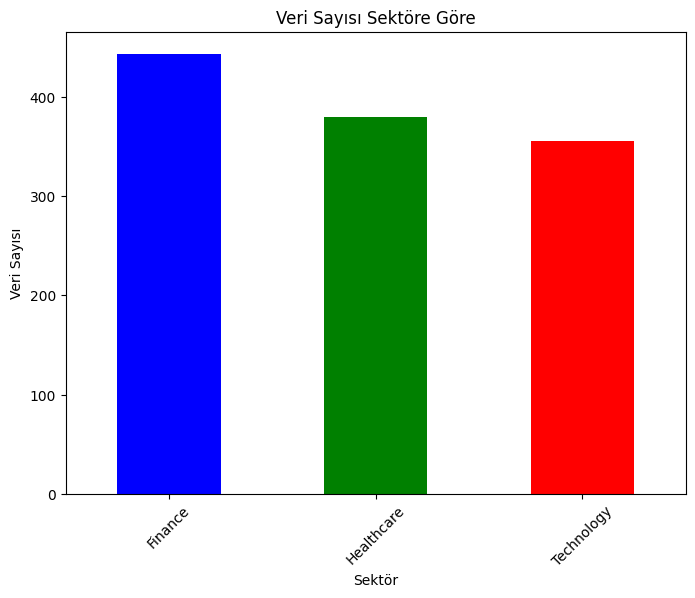

In [ ]:
import matplotlib.pyplot as plt

# Sektöre göre veri sayısını hesapla
sector_counts = data_full_monthly['sector'].value_counts()

# Sektörlerin isimlerini tanımla
sector_names = {0: 'Finance', 1: 'Technology', 2: 'Healthcare'}

# Grafik oluşturma
plt.figure(figsize=(8, 6))
sector_counts.index = sector_counts.index.map(sector_names)  
sector_counts.plot(kind='bar', color=['blue', 'green', 'red'])

# Grafik başlık ve etiketleri
plt.title('Veri Sayısı Sektöre Göre')
plt.xlabel('Sektör')
plt.ylabel('Veri Sayısı')
plt.xticks(rotation=45)

# Grafiği göster
plt.show()


## Veriyi tsfresh için uygun hale getiriyoruz

In [5]:

# Sector bilgisini ayrı bir tabloya al
sector_info = data_full_monthly[["sector"]].reset_index().rename(columns={"index": "id"})
data_long = data_full_monthly.drop(columns=["sector"]).reset_index().melt(id_vars=["index"], var_name="time", value_name="Close")

# Kolon isimlerini tsfresh formatına uygun hale getir
data_long.rename(columns={"index": "id"}, inplace=True)

# Tarihleri datetime formatına çevir
data_long["time"] = pd.to_datetime(data_long["time"])

# Sector bilgisini data_long'a merge et
data_long_monthly = data_long.merge(sector_info, on="id", how="left")

print(data_long_monthly.head())
print(len(data_long_monthly))

     id       time  Close  sector
0  AAME 2005-01-31    NaN       0
1    AB 2005-01-31    NaN       0
2  ABCB 2005-01-31    NaN       0
3  ACGL 2005-01-31    NaN       0
4  ACIC 2005-01-31    NaN       0
284834


# Veri doldurma ve çıkarma
- Burada bir çok yöntem denedim fakat en yüksek doğruluğu nan olan değerleri veri setinden çıkararak elde ettim denediğim yöntemler aşağıdadır:
- data_long_monthly['Close'] = data_long_monthly.groupby('id')['Close'].ffill().bfill()
- data_long_monthly['Close'] = data_long_monthly.groupby('id')['Close'].fillna(0)
- Simple imputer ile medyan ve mean parametreleri ile boşluk doldurma yaptım

In [6]:
data_long_monthly = data_long_monthly.dropna(subset=["Close"])

# Veri ölçekleme
- Burada kullandığım yöntemler MinMaxScaler ve StandardScaler oldu bu iki yöntemden en doğru sonucu veren MinMaxScaler oldu o yüzden kod tarafında onu koydum. 

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler_minMax_monthly = MinMaxScaler()

data_long_monthly['Close'] = scaler_minMax_monthly.fit_transform(data_long_monthly['Close'].values.reshape(-1, 1)).ravel()


# Tsfresh Toolu
- Burada tsfresh için hazır hale getirdiğim veriyi tsfreshin extract_features metoduna verdim ve bizim için zaman serisi verimizden özellikler analizler çıkardı
- Burada default_fc_parameters=MinimalFCParameters kullanmamın sebebi ise daha hızlı sonuçlar vermesiydi

In [10]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

# Özellik çıkarımı için gerekli kolonları seçelim
features = data_long_monthly[['id', 'time', 'Close']]

# Otomatik özellik çıkarımı
# MinimalFCParameters kullanarak daha hızlı işlem yapabiliriz
features = extract_features(features, 
                                   column_id="id", 
                                   column_sort="time",
                                   default_fc_parameters=MinimalFCParameters())
# "id" sütunu index olarak kalmış olabilir, kontrol edelim
features = features.reset_index()
features.rename(columns={"index": "id"}, inplace=True)
# Sector bilgisini tekrar ekleyelim
features = features.merge(sector_info, on="id", how="left")



Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 21.54it/s]


# Select features
- Burada select features kullanarak elde edilen özellikleri azaltmak için kullanmıştım fakat çok artırmadığı için RFE ile özellik çıkarımı yaptım

In [109]:
'''
from tsfresh.feature_selection import select_features

X=features.drop(columns=['sector','id'],axis=1)
y =features['sector']
# Hedef değişkenin olsun (örnek olarak "y" diye tanımlayalım)
selected_features = select_features(X,y)

print(f"Önceki shape: {features.shape}, Sonraki shape: {selected_features.shape}")
'''

Önceki shape: (1177, 12), Sonraki shape: (1177, 9)


In [112]:
'''
# Veri birleştirme
data_full = pd.concat([selected_features, y, features['id']], axis=1)

# 'id' sütununu en başa almak için sıralama
columns = ['id'] + [col for col in data_full.columns if col != 'id']
data_full = data_full[columns]
'''

# Model oluşturma ve Koşturma

In [166]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import catboost as cb

'''
# Veriyi eğitim ve test setlerine ayırma
X = final_features.drop('sector', axis=1)
y = final_features['sector']
'''

X = features.drop(columns=['id', 'sector'])  # 'id' ve 'y' sütunlarını çıkartıyoruz
y = features['sector']  # 'y' hedef değişkeni

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Recursive Feature Elimination (RFE) ile en iyi 7 özelliği seçme
selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=8)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Model parametreleri
rf_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]   
}

gb_params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10]
}

svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

knn_params = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
}

cb_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 10]
}

# Model listesi
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), rf_params),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), gb_params),
    'Support Vector Classifier': (SVC(random_state=42, probability=True), svc_params),
    'K-Nearest Neighbors': (KNeighborsClassifier(), knn_params),
    'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params),
    'CatBoost': (cb.CatBoostClassifier(verbose=0, random_state=42), cb_params),
}

# Her model için sonuçları saklayacağımız sözlük
results = {}

# Her model için eğitim ve değerlendirme
for name, (model, params) in models.items():
    print(f"\nModel: {name}")
    
    # Grid Search ile hiperparametre optimizasyonu
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # En iyi model
    best_model = grid_search.best_estimator_
    
    # Cross-validation skorları
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
    
    # Test seti üzerinde tahminler
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Metriklerin hesaplanması
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    # Sonuçları sakla
    results[name] = {
        'Best Parameters': grid_search.best_params_,
        'Cross-val Mean Score': cv_scores.mean(),
        'Cross-val Std': cv_scores.std(),
        'Test Accuracy': accuracy,
        'Test F1-Score': f1,
        'Test ROC-AUC': roc_auc
    }
    
    print(f"En iyi parametreler: {grid_search.best_params_}")
    print(f"Cross-validation ortalama skor: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test seti doğruluk oranı: {accuracy:.4f}")
    print(f"Test seti F1-score: {f1:.4f}")
    print(f"Test seti ROC-AUC: {roc_auc:.4f}")
    print("\nDetaylı sınıflandırma raporu:")
    print(classification_report(y_test, y_pred))

# En iyi modeli bulma
best_model_name = max(results.items(), key=lambda x: x[1]['Test Accuracy'])[0]
print(f"\nEn iyi performans gösteren model: {best_model_name}")
print("\nTüm modellerin karşılaştırmalı sonuçları:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        if isinstance(value, dict):
            print(f"{metric_name}:")
            for param, param_value in value.items():
                print(f"    {param}: {param_value}")
        else:
            print(f"{metric_name}: {value:.4f}")



Model: Random Forest
En iyi parametreler: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Cross-validation ortalama skor: 0.6526 (+/- 0.1136)
Test seti doğruluk oranı: 0.6695
Test seti F1-score: 0.6691
Test seti ROC-AUC: 0.8138

Detaylı sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        92
           1       0.60      0.58      0.59        69
           2       0.58      0.59      0.58        75

    accuracy                           0.67       236
   macro avg       0.66      0.66      0.66       236
weighted avg       0.67      0.67      0.67       236


Model: Gradient Boosting
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Cross-validation ortalama skor: 0.6472 (+/- 0.0911)
Test seti doğruluk oranı: 0.6483
Test seti F1-score: 0.6492
Test seti ROC-AUC: 0.8019

Detaylı sınıflandırma raporu:
              precision    recall  f1-score  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En iyi parametreler: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Cross-validation ortalama skor: 0.5718 (+/- 0.0879)
Test seti doğruluk oranı: 0.5763
Test seti F1-score: 0.5679
Test seti ROC-AUC: 0.7500

Detaylı sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71        92
           1       0.49      0.48      0.49        69
           2       0.53      0.43      0.47        75

    accuracy                           0.58       236
   macro avg       0.56      0.56      0.56       236
weighted avg       0.57      0.58      0.57       236


Model: XGBoost
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Cross-validation ortalama skor: 0.6494 (+/- 0.0977)
Test seti doğruluk oranı: 0.6356
Test seti F1-score: 0.6351
Test seti ROC-AUC: 0.8138

Detaylı sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.76      0.77      0.7

# Elde edilen en iyi model
- ELde edilen en iyi model CatBoost çıkmıştır 
- CatBoost:
- Best Parameters: 
    - depth: 5
    - iterations: 200
    - learning_rate: 0.1
- Cross-val Mean Score: 0.6494
- Cross-val Std: 0.0516
- Test Accuracy: 0.6780
- Test F1-Score: 0.6774
- Test ROC-AUC: 0.8170


In [167]:
best_model

# Sektörel Benzerlik Analizi
- Proje ayrıntılarında bahsedilen real_estate için sektörel benzerlik analizi yaptım ve elde edilen sonuçlar grafiklerle aşağıda bulunmaktadır.
- Aşağıdaki kodlarda sırayla kodumuzun en başında yaptığımız gibi veriyi tsfreshe uygun hale getirdim ve modele verecek şekilde düzenledim.
- Bir nevi aynı işlemlerden geçirdim


In [199]:
data_monthly_real_estate = pd.read_csv('/kaggle/input/tickerdata2/data_monthly_real_estate.csv',index_col=0)

real_estate_index=filter_stocks_by_missing_data(data_monthly_real_estate,20)

data_monthly_real_estate = data_monthly_real_estate.T.loc[real_estate_index,:]
data_full_monthly_real_estate = data_monthly_real_estate.copy()

# "sector" sütununu kaldır ve uzun formata dönüştür
data_long_real_estate = data_full_monthly_real_estate.reset_index().melt(id_vars=["index"], var_name="time", value_name="Close")

# Kolon isimlerini tsfresh formatına uygun hale getir
data_long_real_estate.rename(columns={"index": "id"}, inplace=True)

# Tarihleri datetime formatına çevir
data_long_real_estate["time"] = pd.to_datetime(data_long_real_estate["time"])
data_long_monthly_real_estate=data_long_real_estate.copy()

print(data_long_monthly_real_estate.head())

     id       time  Close
0   ABR 2005-01-31    NaN
1   ACR 2005-01-31    NaN
2   ADC 2005-01-31    NaN
3  AGNC 2005-01-31    NaN
4   AHT 2005-01-31    NaN


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


- Real-estate veri setine önce dropna sonra minmax uygulanarak train veri setinin formatına uygun hale getirilip daha doğru benzerlik sonucu almak için işlemleri gerçekleştirdim

In [200]:
data_long_monthly_real_estate = data_long_monthly_real_estate.dropna(subset=["Close"])

data_long_monthly_real_estate['Close'] = scaler_minMax_monthly.transform(data_long_monthly_real_estate['Close'].values.reshape(-1, 1)).ravel()
data_long_monthly_real_estate.isna().sum()

id       0
time     0
Close    0
dtype: int64

- Tsfresh için veri uygun formata getirilip sonuçları extracted_features_real_estate değişkeninde topladım

In [201]:
# 🟢 1. Real Estate verisini uygun hale getirme (Özellik çıkarımı)
features_real_estate = data_long_monthly_real_estate[['id', 'time', 'Close']]
extracted_features_real_estate = extract_features(features_real_estate, 
                                                  column_id="id", 
                                                  column_sort="time",
                                                  default_fc_parameters=MinimalFCParameters())

# "id" sütunu index olarak kalmış olabilir, kontrol edelim
extracted_features_real_estate = extracted_features_real_estate.reset_index()
extracted_features_real_estate.rename(columns={"index": "id"}, inplace=True)

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 121.60it/s]


In [ ]:
features_x = extracted_features_real_estate.drop(columns=['id'])  # 'id' sütununu çıkarttım çünkü veriyi eğitirken kullanmamdım
# RFE ile özellik çıkarma yaptım transform yaparak aynı sütunun çıkarılmasını sağladım
feature_x_select=selector.transform(features_x)
# Daha önce eğittiğimiz en iyi model ile tahmin yapma

real_estate_predictions = best_model.predict(feature_x_select)
real_estate_predictions = real_estate_predictions.flatten()


- Verinin indexini id olarak değiştirdim ki görselleştirme için kullanmam daha kolay olsun

In [203]:
extracted_features_real_estate.set_index('id', inplace=True)


# Real_estate verisi için sektörel benzerlik grafikleri

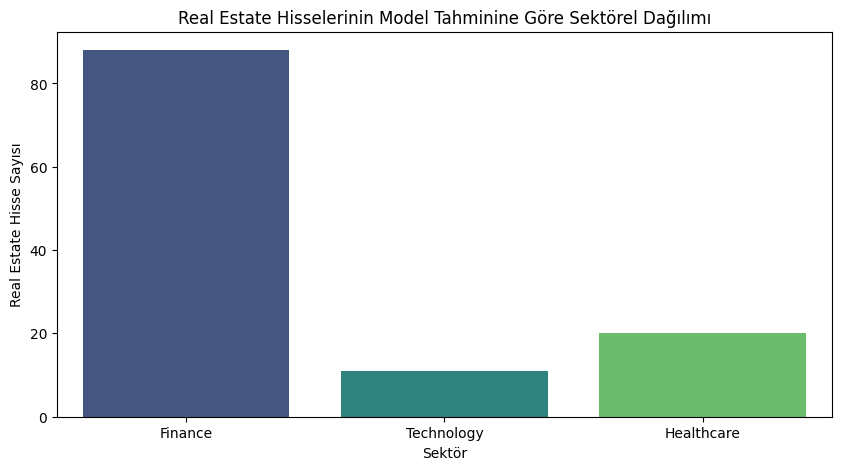

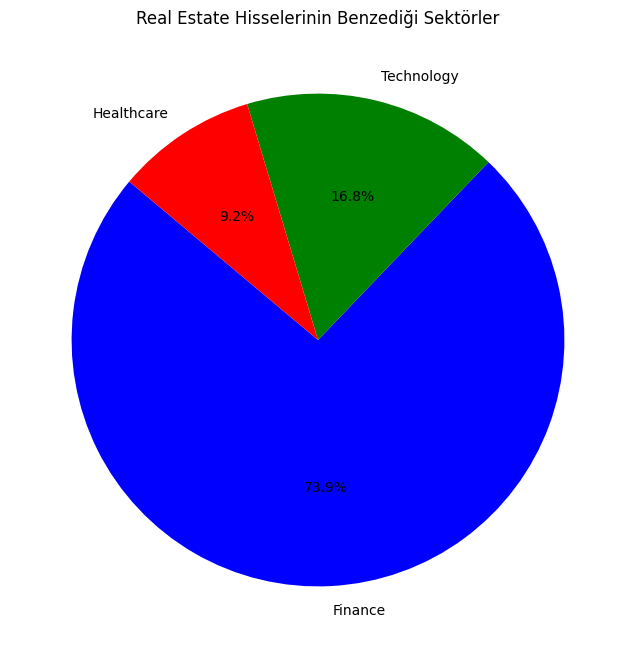

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
# 🟢 3. Tahminleri dataframe'e ekleyelim
real_estate_results = pd.DataFrame({
    "Stock_ID": extracted_features_real_estate.index,
    "Predicted_Sector": real_estate_predictions
})

# 🟢 4. Sonuçları görselleştirme
plt.figure(figsize=(10, 5))
sns.countplot(x=real_estate_results["Predicted_Sector"], palette="viridis")
plt.xticks(ticks=[0, 1, 2], labels=["Finance", "Technology", "Healthcare"])
plt.xlabel("Sektör")
plt.ylabel("Real Estate Hisse Sayısı")
plt.title("Real Estate Hisselerinin Model Tahminine Göre Sektörel Dağılımı")
plt.show()

# 🟢 5. Pasta grafiği ile gösterelim
sector_counts = real_estate_results["Predicted_Sector"].value_counts()
labels = ["Finance", "Technology", "Healthcare"]

plt.figure(figsize=(8, 8))
plt.pie(sector_counts, labels=labels, autopct="%1.1f%%", colors=["blue", "green", "red"], startangle=140)
plt.title("Real Estate Hisselerinin Benzediği Sektörler")
plt.show()

- Yukarıda real_estatin en çok benzediği sektör finance olarak seçilmiş tabi modelin doğruluğu düşük olduğundan yanlış bir benzerlik analizi yapması olasıdır

# Model performanslarının karşılaştırılması

<Figure size 1000x600 with 0 Axes>

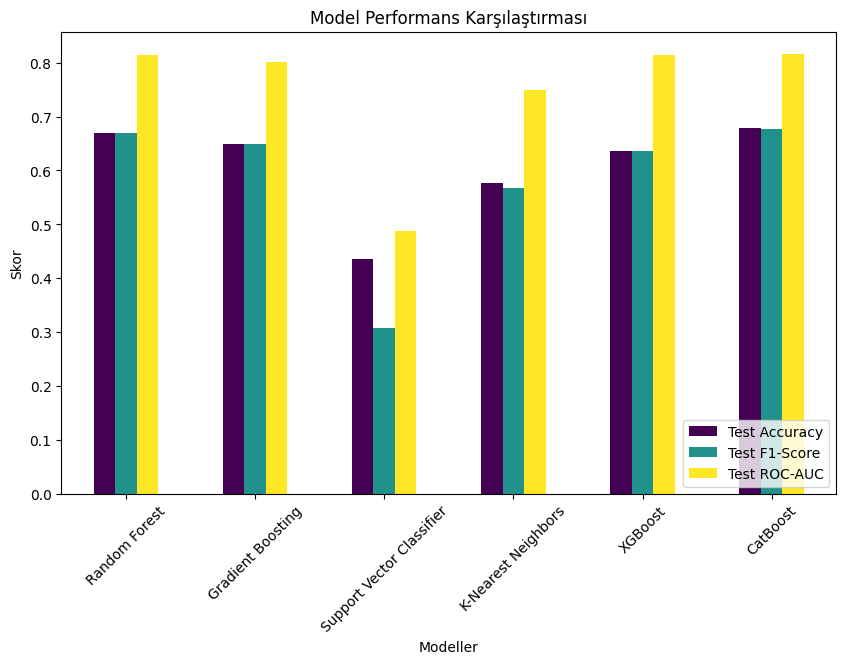

In [205]:
# Model performans metriklerini çubuk grafikte gösterme
metrics_df = pd.DataFrame(results).T[['Test Accuracy', 'Test F1-Score', 'Test ROC-AUC']]

plt.figure(figsize=(10, 6))
metrics_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performans Karşılaştırması")
plt.xlabel("Modeller")
plt.ylabel("Skor")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


# Zaman serisi grafikleri
- Burada en başta birleştirdiğimiz teknoloji, finans ve sağlık sektörlerine ait 5 verinin görünümü ve real_estatedeki verilerin grafiği verilmektedir.

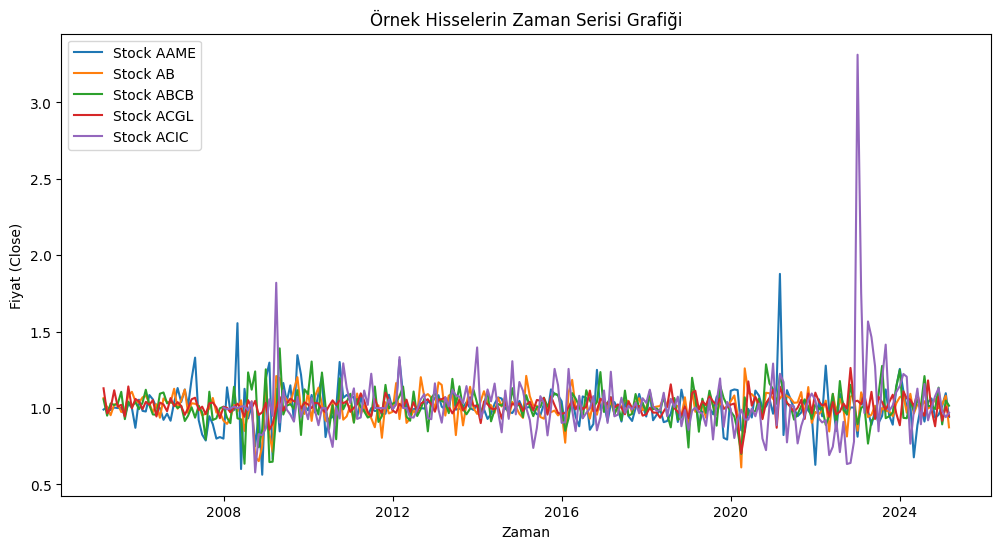

In [239]:
import matplotlib.pyplot as plt

# Örnekleme yapmak için birkaç hisseyi seçelim
sample_stocks = data_long_monthly[data_long_monthly['id'].isin(data_long_monthly['id'].unique()[:5])]

plt.figure(figsize=(12, 6))
for stock in sample_stocks['id'].unique():
    stock_data = sample_stocks[sample_stocks['id'] == stock]
    plt.plot(stock_data['time'], stock_data['Close'], label=f'Stock {stock}')

plt.xlabel('Zaman')
plt.ylabel('Fiyat (Close)')
plt.title('Örnek Hisselerin Zaman Serisi Grafiği')
plt.legend()
plt.show()


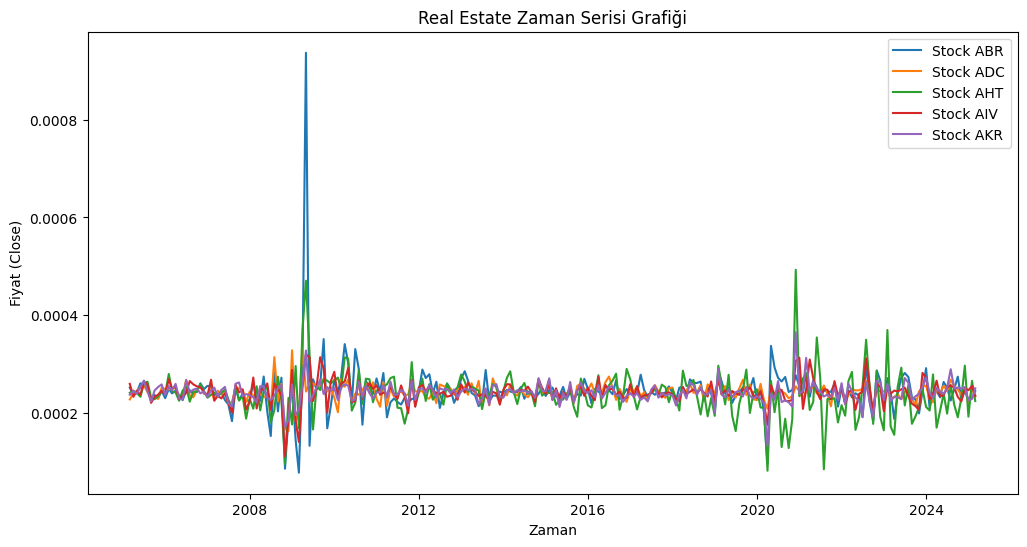

In [209]:
import matplotlib.pyplot as plt

# Örnekleme yapmak için birkaç hisseyi seçelim
sample_stocks = data_long_monthly_real_estate[data_long_monthly_real_estate['id'].isin(data_long_monthly_real_estate['id'].unique()[:5])]

plt.figure(figsize=(12, 6))
for stock in sample_stocks['id'].unique():
    stock_data = sample_stocks[sample_stocks['id'] == stock]
    plt.plot(stock_data['time'], stock_data['Close'], label=f'Stock {stock}')

plt.xlabel('Zaman')
plt.ylabel('Fiyat (Close)')
plt.title('Real Estate Zaman Serisi Grafiği')
plt.legend()
plt.show()
